In [1]:
import torch
import torchaudio

In [2]:

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu102
0.11.0+cu102


In [3]:
import io
import os
import tarfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio, display

In [10]:
data_root_path = 'audio_study/data/'

In [23]:
SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(data_root_path+'study_data', "steam.mp3")

SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(data_root_path+'study_data', "steam.wav")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(data_root_path+'study_data', "steam.gsm")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(data_root_path+'study_data', "speech.wav")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(data_root_path+'study_data', "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

In [24]:
def fetch_data():
    os.makedirs(data_root_path, exist_ok=True)
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
        (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
    ]
    for url, path in uri:
        with open(path, 'wb') as file_:
            file_.write(requests.get(url).content)
fetch_data()

In [13]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [14]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    # 双通道就画两张子图
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [15]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        # 绘制频谱图
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [16]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [17]:
def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

In [18]:
def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")

In [22]:
## 获取audio的metadata
metadata_mp3 = torchaudio.info(SAMPLE_MP3_PATH)
print(type(metadata_mp3))
print(metadata_mp3)
# metadata是描述音频的信息
# 有采样率 frame个数 channel的个数 每个样本的位数(具有压缩和可变比特的为0 如mp3) 编码形式
# frame的个数是110559 frame代表的整个音频有多少采样点
# 采样率是44100 那么音频的总时间就是 frame / sample_rate = 2.5s

<class 'torchaudio.backend.common.AudioMetaData'>
AudioMetaData(sample_rate=44100, num_frames=110559, num_channels=2, bits_per_sample=0, encoding=MP3)


In [25]:
metadata_wav = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata_wav)
metadata_gsm = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata_gsm)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


In [28]:
print(torchaudio.info(SAMPLE_WAV_SPEECH_PATH))

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [30]:
# load接口导入
waveform, sample_rate = torchaudio.load(SAMPLE_MP3_PATH)

In [31]:
print_stats(waveform,sample_rate)
# 采样率16000 channel是1单声道 有54400frame 数值都是归一化到[-1,1]

Sample Rate: 44100
Shape: (2, 109440)
Dtype: torch.float32
 - Max:      0.487
 - Min:     -0.434
 - Mean:     0.000
 - Std Dev:  0.112

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0205, -0.0208, -0.0212],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0190, -0.0197, -0.0196]])



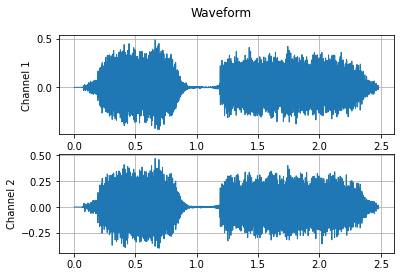

In [32]:
plot_waveform(waveform,sample_rate)

/home/wy/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


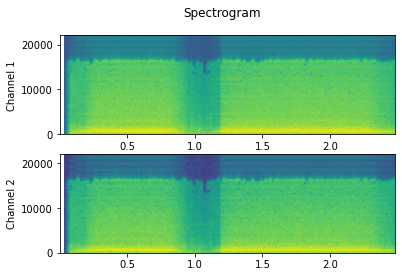

In [33]:
plot_specgram(waveform, sample_rate)

In [34]:
play_audio(waveform, sample_rate)